# Capstone Two: Feature Engineering

In this step for my capstone, I am going to use my insights from the EDA step as well as tools like featuretools

The general plan for this notebook will be: 

1. Import the data.
2. Add features using EDA and other insights. 
3. Save the new DataFrames. 

# 1. Import the data.

In [75]:
import numpy as np
import pandas as pd
from itertools import product

import warnings
warnings.filterwarnings('ignore')

import time
import os
from library.sb_utils import save_file

pd.options.display.float_format = '{:.2f}'.format

In [76]:
sales = pd.read_csv("./data/clean/clean_sales_train.csv")
test = pd.read_csv('./data/clean/clean_test.csv').set_index('ID') # retain the ID data by setting it to the index
shops = pd.read_csv("./data/clean/clean_shops.csv")
items = pd.read_csv("./data/clean/clean_items.csv")
categories = pd.read_csv("./data/clean/clean_item_categories.csv")

In [77]:
sales['datetime'] = pd.to_datetime(sales.datetime)

In [78]:
sales.dtypes

date                      object
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
datetime          datetime64[ns]
dtype: object

In [79]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datetime
0,02.01.2013,0,59,22154,999.00,1.00,2013-01-02
1,03.01.2013,0,25,2552,899.00,1.00,2013-01-03
2,05.01.2013,0,25,2552,899.00,-1.00,2013-01-05
3,06.01.2013,0,25,2554,1709.05,1.00,2013-01-06
4,15.01.2013,0,25,2555,1099.00,1.00,2013-01-15


It's fine that date and datetime are non-numeric since we will be using them to add featues.

### Important! 
I am appending the test data onto the training data (sales) so that I can add all the features in one fell swoop. That final dataframe can be seperated by date_block_num for the training and testing section in the machine learning. 

There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train data. As such, many items and item/shop pairs should simply have a 0. We want the training and testing data to be similar, so we are going to calculate the monthly sales and set any unique, unseen pair so 0s. 

In [80]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales_month = sales[sales.date_block_num==i]
    matrix.append(np.array(list(product([i], sales_month.shop_id.unique(), sales_month.item_id.unique())), dtype='int16'))

df = pd.DataFrame(np.vstack(matrix), columns=cols)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df.sort_values(cols,inplace=True)

Now we aggregate into monthly data.

In [81]:
group = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .astype(np.float16))

In [82]:
df[df.item_cnt_month>0].head()

,date_block_num,shop_id,item_id,item_cnt_month
4,0,0,32,6.00
5,0,0,33,3.00
7,0,0,35,1.00
11,0,0,43,1.00
19,0,0,51,2.00


In [83]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [84]:
df = pd.concat([df, test], ignore_index=True, sort=False, keys=cols)
df.fillna(0, inplace=True) # 34 month

In [85]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.00
1,0,0,27,0.00
2,0,0,28,0.00
3,0,0,29,0.00
4,0,0,32,6.00


# 2. Add features by hand using EDA insights.

Here are the major insights from the EDA step. 

1. The data is seasonal. There is a spike in sales during certain months, like December. 
2. The stores that sold best were in Moscow or online retailers/warehouses.  
3. The items that sold best are games, specifically video games. There were spikes in sale data on game releases.  
4. The weekends sold more than the weekdays. 
5. Holidays impacted the number of sales. 
6. There was a general negative trend in sale data. 


This means I am going to implement the following features: 
1. Number of holidays per month (numerical)
2. Number of weekend days per month (numerical)
3. Monthly revenue per item per shop (numerical)
4. Month (categorical)
5. Days per month (numerical)
6. Group (categorical)
7. First month sale of item
8. Number of months since last sale of item


1. Month (categorical)
2. Group (categorical)
3. Number of holidays per month (numerical)
4. Number of weekend days per month (numerical)

I am leaving out location and online/brick and mortal information since that is beyond the scope of my project. 

I am also going to add other helpful features: monthly revenue per item per shop, days since last sale, and total item sale count. This should help to capture some of the store info from location that I am excluding. The general negative trend is captured by date block num. 

### 2.1 Number of holidays per month (numerical)

First, select each day that is a holiday. Later, when we aggregate into monthly data, we will sum the number of holidays. 

In [86]:
# List of all Russian public hoildays 2013-2015
holidays = ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10', '2013-02-21', '2013-02-22',
               '2013-02-23', '2013-03-06', '2013-03-07', '2013-03-08',
               '2013-05-01', '2013-05-02', '2013-05-03', '2013-05-08',
               '2013-05-09', '2013-05-10', '2013-06-12', '2013-11-04',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10', '2014-02-21', '2014-02-22',
               '2014-02-23', '2014-03-06', '2014-03-07', '2014-03-08',
               '2014-05-01', '2014-05-02', '2014-05-03', '2014-05-08',
               '2014-05-09', '2014-05-10', '2014-06-12', '2014-11-04',
               '2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-02-23', '2015-03-08', '2015-03-09',
               '2015-05-01', '2015-05-04', '2015-05-09', '2015-05-11',
               '2015-06-12', '2015-11-04']

In [87]:
sales.loc[sales['datetime'].isin(holidays), 'holiday'] = 1
sales.fillna(0, inplace=True)

In [88]:
sales.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datetime,holiday
1962968,15.09.2014,20,35,3076,799.00,1.00,2014-09-15,0.00
48685,24.01.2013,0,15,10401,524.54,1.00,2013-01-24,0.00
2282839,30.12.2014,23,6,6847,299.00,1.00,2014-12-30,0.00
1563442,19.04.2014,15,57,7524,299.00,1.00,2014-04-19,0.00
2338700,09.01.2015,24,6,15134,179.00,1.00,2015-01-09,1.00


### 2.2 Number of weekend days per month (numerical)

Like holidays, I am going to add the weekend value then aggregate later. 

In [89]:
sales['num_weekend_days'] = ((pd.DatetimeIndex(sales.datetime).dayofweek) // 5 == 1).astype(float)

### 2.3 Monthly revenue per item per shop (numerical)

Like the two above, I am going to do daily information now and aggregate later.

In [90]:
sales['revenue'] = sales['item_cnt_day'] * sales['item_price']

In [91]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datetime,holiday,num_weekend_days,revenue
0,02.01.2013,0,59,22154,999.00,1.00,2013-01-02,1.00,0.00,999.00
1,03.01.2013,0,25,2552,899.00,1.00,2013-01-03,1.00,0.00,899.00
2,05.01.2013,0,25,2552,899.00,-1.00,2013-01-05,1.00,1.00,-899.00
3,06.01.2013,0,25,2554,1709.05,1.00,2013-01-06,1.00,1.00,1709.05
4,15.01.2013,0,25,2555,1099.00,1.00,2013-01-15,0.00,0.00,1099.00
5,10.01.2013,0,25,2564,349.00,1.00,2013-01-10,1.00,0.00,349.00
6,02.01.2013,0,25,2565,549.00,1.00,2013-01-02,1.00,0.00,549.00
7,04.01.2013,0,25,2572,239.00,1.00,2013-01-04,1.00,0.00,239.00
8,11.01.2013,0,25,2572,299.00,1.00,2013-01-11,0.00,0.00,299.00
9,03.01.2013,0,25,2573,299.00,3.00,2013-01-03,1.00,0.00,897.00


### Aggregate into monthly data

In [92]:
agg = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'revenue':'sum', 'item_price':'mean','item_cnt_day':'sum','revenue':'sum'})

In [93]:
agg.head(10)

revenue  item_price  item_cnt_day
date_block_num shop_id item_id                                   
0              0       32       1326.00      221.00          6.00
                       33       1041.00      347.00          3.00
                       35        247.00      247.00          1.00
                       43        221.00      221.00          1.00
                       51        257.00      128.50          2.00
                       61        195.00      195.00          1.00
                       75         76.00       76.00          1.00
                       88         76.00       76.00          1.00
                       95        193.00      193.00          1.00
                       96         70.00       70.00          1.00

In [94]:
df = df.merge(agg, on=["shop_id", "item_id","date_block_num"], how='left')

In [95]:
df.fillna(0, inplace=True)
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price,item_cnt_day
0,0,0,19,0.00,0.00,0.00,0.00
1,0,0,27,0.00,0.00,0.00,0.00
2,0,0,28,0.00,0.00,0.00,0.00
3,0,0,29,0.00,0.00,0.00,0.00
4,0,0,32,6.00,1326.00,221.00,6.00


In [96]:
agg = sales.groupby(['date_block_num','date']).agg({'holiday':'mean','num_weekend_days':'mean'})

In [97]:
agg.head()

holiday  num_weekend_days
date_block_num date                                 
0              01.01.2013     1.00              0.00
               02.01.2013     1.00              0.00
               03.01.2013     1.00              0.00
               04.01.2013     1.00              0.00
               05.01.2013     1.00              1.00

In [98]:
agg = agg.groupby('date_block_num').agg({'holiday':'sum','num_weekend_days':'sum'})

In [99]:
df = df.merge(agg, on=["date_block_num"], how='left')

In [100]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price,item_cnt_day,holiday,num_weekend_days
0,0,0,19,0.00,0.00,0.00,0.00,10.00,8.00
1,0,0,27,0.00,0.00,0.00,0.00,10.00,8.00
2,0,0,28,0.00,0.00,0.00,0.00,10.00,8.00
3,0,0,29,0.00,0.00,0.00,0.00,10.00,8.00
4,0,0,32,6.00,1326.00,221.00,6.00,10.00,8.00


### 2.4 Month (categorical)

In [101]:
df['month'] = df['date_block_num'] % 12

In [102]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price,item_cnt_day,holiday,num_weekend_days,month
0,0,0,19,0.00,0.00,0.00,0.00,10.00,8.00,0
1,0,0,27,0.00,0.00,0.00,0.00,10.00,8.00,0
2,0,0,28,0.00,0.00,0.00,0.00,10.00,8.00,0
3,0,0,29,0.00,0.00,0.00,0.00,10.00,8.00,0
4,0,0,32,6.00,1326.00,221.00,6.00,10.00,8.00,0


### 2.5 Days per month

In [103]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
df['days'] = df['month'].map(days).astype(np.int8)

In [104]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_price,item_cnt_day,holiday,num_weekend_days,month,days
0,0,0,19,0.00,0.00,0.00,0.00,10.00,8.00,0,31
1,0,0,27,0.00,0.00,0.00,0.00,10.00,8.00,0,31
2,0,0,28,0.00,0.00,0.00,0.00,10.00,8.00,0,31
3,0,0,29,0.00,0.00,0.00,0.00,10.00,8.00,0,31
4,0,0,32,6.00,1326.00,221.00,6.00,10.00,8.00,0,31


In [105]:
df = df.rename(columns={'item_price':'item_monthly_avg_price','holiday':'num_holiday_month'})
df.drop('item_cnt_day', axis=1, inplace=True)

In [106]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_monthly_avg_price,num_holiday_month,num_weekend_days,month,days
0,0,0,19,0.00,0.00,0.00,10.00,8.00,0,31
1,0,0,27,0.00,0.00,0.00,10.00,8.00,0,31
2,0,0,28,0.00,0.00,0.00,10.00,8.00,0,31
3,0,0,29,0.00,0.00,0.00,10.00,8.00,0,31
4,0,0,32,6.00,1326.00,221.00,10.00,8.00,0,31


### 2.6 Group (categorical)

In [107]:
# add item category id
df = pd.merge(df, items[['item_id','item_category_id']], on='item_id', how='left')
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_monthly_avg_price,num_holiday_month,num_weekend_days,month,days,item_category_id
0,0,0,19,0.00,0.00,0.00,10.00,8.00,0,31,40
1,0,0,27,0.00,0.00,0.00,10.00,8.00,0,31,19
2,0,0,28,0.00,0.00,0.00,10.00,8.00,0,31,30
3,0,0,29,0.00,0.00,0.00,10.00,8.00,0,31,23
4,0,0,32,6.00,1326.00,221.00,10.00,8.00,0,31,40


In [108]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#create broader category groupings, where group is general and item_category is more specific
categories['group_name'] = categories['item_category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
#label encode group names
categories['group_id']  = le.fit_transform(categories.group_name.values)
print("Number of groups:", len(categories['group_id'].unique()))
print("Number of categories:", len(categories['item_category_id'].unique()))
categories.sample(5)

Number of groups: 18
Number of categories: 84


,item_category_name,item_category_id,group_name,group_id
75,Программы - Для дома и офиса,75,Программы,14
78,Программы - Обучающие (Цифра),78,Программы,14
1,Аксессуары - PS2,1,Аксессуары,1
44,Книги - Аудиокниги (Цифра),44,Книги,11
49,Книги - Методические материалы 1С,49,Книги,11


In [109]:
df = pd.merge(df, categories, on = 'item_category_id', how='left') 
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_monthly_avg_price,num_holiday_month,num_weekend_days,month,days,item_category_id,item_category_name,group_name,group_id
0,0,0,19,0.00,0.00,0.00,10.00,8.00,0,31,40,Кино - DVD,Кино,10
1,0,0,27,0.00,0.00,0.00,10.00,8.00,0,31,19,Игры - PS3,Игры,5
2,0,0,28,0.00,0.00,0.00,10.00,8.00,0,31,30,Игры PC - Стандартные издания,Игры PC,8
3,0,0,29,0.00,0.00,0.00,10.00,8.00,0,31,23,Игры - XBOX 360,Игры,5
4,0,0,32,6.00,1326.00,221.00,10.00,8.00,0,31,40,Кино - DVD,Кино,10


### 2.7 First month sale of item

### TODO

Add previous sales data (how many times it has sold)

Mean first month sales per item

First month that it sold

### 2.8 Number of months since last sale of item

For this, I simply search for the item in a dictionary. If the item is not in the dictionary, then it is the first sale so the value will be some null value (-1). If the item is in the list, then the value is the difference between the current row date and the stored  date. Then update the store value date with the current row date. 

In [110]:
test_df = df[df.date_block_num<2]

In [111]:
test_df['item_cnt_month']=test_df['item_cnt_month'].astype('float16')

In [116]:
ts = time.time()
hist = {}

test_df['item_months_since_last_sale'] = -1
test_df['item_months_since_last_sale'] = test_df['item_months_since_last_sale'].astype(np.int8)

for x, row in test_df.iterrows(): 
    key = row.item_id
    #print(key)
    if key not in hist:
#         print("key not in list")
#         print(type(0))
#         print(type(row.item_cnt_month))
#         print(row.item_cnt_month)
        if row.item_cnt_month != 0:
            hist[key]=row.date_block_num
            #print(hist[key])
    else: 
        #print('we got one')
        last_date_block_num = hist[key]
        if row.date_block_num > last_date_block_num:
            test_df.at[x, 'item_months_since_last_sale'] = row.date_block_num - last_date_block_num
            hist[key] = row.date_block_num
    #print('n+')   
print(time.time()-ts, "seconds", (time.time()-ts)/60.0,"minutes")

31.31654691696167 seconds 0.5219424486160278 minutes


In [120]:
ts = time.time()
hist = {}

df['item_months_since_last_sale'] = -1

for x, row in df.iterrows(): 
    key = row.item_id
    if key not in hist:
        if row.item_cnt_month is not 0:
            hist[key]=row.date_block_num
    else: 
        last_date_block_num = hist[key]
        if row.date_block_num > last_date_block_num:
            df.at[x, 'item_months_since_last_sale'] = row.date_block_num - last_date_block_num
            hist[key] = row.date_block_num
                
print(time.time()-ts, "seconds", (time.time()-ts)/60.0,"minutes")

456.2357437610626 seconds 7.603929062684377 minutes


In [121]:
df[df.item_months_since_last_sale>-1].head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_monthly_avg_price,num_holiday_month,num_weekend_days,month,days,item_category_id,item_category_name,group_name,group_id,item_months_since_last_sale
365176,1,0,27,0.00,0.00,0.00,3.00,8.00,1,28,19,Игры - PS3,Игры,5,1
365177,1,0,28,0.00,0.00,0.00,3.00,8.00,1,28,30,Игры PC - Стандартные издания,Игры PC,8,1
365180,1,0,32,10.00,2210.00,221.00,3.00,8.00,1,28,40,Кино - DVD,Кино,10,1
365181,1,0,33,3.00,1041.00,347.00,3.00,8.00,1,28,37,Кино - Blu-Ray,Кино,10,1
365182,1,0,34,0.00,0.00,0.00,3.00,8.00,1,28,40,Кино - DVD,Кино,10,1


Just a test :D

In [146]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)

In [147]:
import xgboost as xgb
model = xgb.XGBRegressor()

ts = time.time()

model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=True)

print(time.time()-ts, "seconds", (time.time()-ts)/60.0,"minutes")

[0]	validation_0-rmse:2.78428	validation_1-rmse:5.04660
[1]	validation_0-rmse:2.44583	validation_1-rmse:4.85349
[2]	validation_0-rmse:2.23801	validation_1-rmse:4.76733
[3]	validation_0-rmse:2.09745	validation_1-rmse:4.69335
[4]	validation_0-rmse:2.02012	validation_1-rmse:4.67468
[5]	validation_0-rmse:1.97598	validation_1-rmse:4.65601
[6]	validation_0-rmse:1.92980	validation_1-rmse:4.64785
[7]	validation_0-rmse:1.90237	validation_1-rmse:4.64226
[8]	validation_0-rmse:1.88902	validation_1-rmse:4.63826
[9]	validation_0-rmse:1.88246	validation_1-rmse:4.63841
[10]	validation_0-rmse:1.87584	validation_1-rmse:4.63552
[11]	validation_0-rmse:1.87227	validation_1-rmse:4.63452
[12]	validation_0-rmse:1.83081	validation_1-rmse:4.40947
[13]	validation_0-rmse:1.82807	validation_1-rmse:4.40867
[14]	validation_0-rmse:1.81247	validation_1-rmse:4.40135
[15]	validation_0-rmse:1.81147	validation_1-rmse:4.39977
[16]	validation_0-rmse:1.78094	validation_1-rmse:4.44020
[17]	validation_0-rmse:1.78017	validation

In [148]:
y_pred = model.predict(X_valid)
y_test = model.predict(X_test)

In [149]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
r2 = r2_score(y_valid, y_pred)
print("R-squared score:",(r2))

mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error:",(mse))

rmse = mean_squared_error(y_valid, y_pred, squared=False)
print("Root mean Squared Error:",(rmse))

R-squared score: 1.0
Mean Squared Error: 20.088379
Root mean Squared Error: 4.482006


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

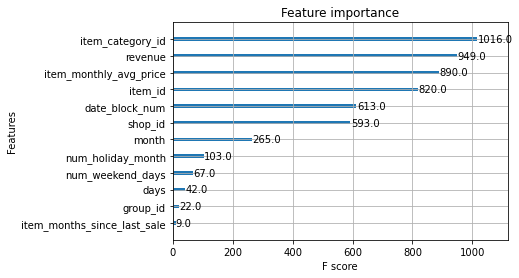

In [150]:
xgb.plot_importance(model)

# 3. Save the new dataframe

In [151]:
# Save the data
datapath = './data/feature_engineered'
save_file(df, 'df_feature_engineered.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "./data/feature_engineered\df_feature_engineered.csv"
